# **INFORMEL TRAINING MODEL**

## **LOADING DATA**

In [10]:
# Import dataset

file_score = "../DATAS/CleanALL_EHCVM_ML.csv"

## **IMPORTS LIBRARIES**

In [11]:
# Imports Libairies

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
import joblib

import warnings

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, LabelBinarizer, label_binarize
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, KFold

from sklearn.metrics import roc_curve, auc, precision_recall_fscore_support
from sklearn.metrics import accuracy_score, precision_score, recall_score, r2_score, mean_squared_error, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV 


In [12]:
# Import Modèles

from sklearn.inspection import DecisionBoundaryDisplay

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

import xgboost as xgb
from xgboost import XGBRegressor

warnings.filterwarnings('ignore')

## **READ DATA**

In [230]:
df_score = pd.read_csv(file_score)
Inf_score = df_score.copy()
Inf_score

,mstat,rev_total_mois,log_revenu,sans_revenu,age_grp,bancarise,a_assurance,logem,Stg_formel
0,Célibataire,279244.0,12.539845,0,25-34,1,0,Locataire,1
1,Célibataire,0.0,0.000000,1,0-17,0,0,Locataire,0
2,Célibataire,0.0,0.000000,1,0-17,0,0,Locataire,0
3,Célibataire,0.0,0.000000,1,0-17,0,0,Locataire,0
4,Marié(e),0.0,0.000000,1,25-34,0,0,Locataire,0
...,...,...,...,...,...,...,...,...,...
64469,Célibataire,0.0,0.000000,1,0-17,0,0,Proprietaire titre,0
64470,Célibataire,0.0,0.000000,1,0-17,0,0,Proprietaire titre,0
64471,Célibataire,0.0,0.000000,1,0-17,0,0,Proprietaire titre,0
64472,Célibataire,0.0,0.000000,1,0-17,0,0,Proprietaire titre,0


In [231]:
Inf_score.isna().sum()

mstat             0
rev_total_mois    0
log_revenu        0
sans_revenu       0
age_grp           0
bancarise         0
a_assurance       0
logem             0
Stg_formel        0
dtype: int64

In [232]:
Inf_score = Inf_score.drop(['log_revenu'], axis=1)
Inf_score

,mstat,rev_total_mois,sans_revenu,age_grp,bancarise,a_assurance,logem,Stg_formel
0,Célibataire,279244.0,0,25-34,1,0,Locataire,1
1,Célibataire,0.0,1,0-17,0,0,Locataire,0
2,Célibataire,0.0,1,0-17,0,0,Locataire,0
3,Célibataire,0.0,1,0-17,0,0,Locataire,0
4,Marié(e),0.0,1,25-34,0,0,Locataire,0
...,...,...,...,...,...,...,...,...
64469,Célibataire,0.0,1,0-17,0,0,Proprietaire titre,0
64470,Célibataire,0.0,1,0-17,0,0,Proprietaire titre,0
64471,Célibataire,0.0,1,0-17,0,0,Proprietaire titre,0
64472,Célibataire,0.0,1,0-17,0,0,Proprietaire titre,0


## **COURBE KDE (Kernel Density Estimator) : Approximation of the probability density of each variable**

Differentes catégories


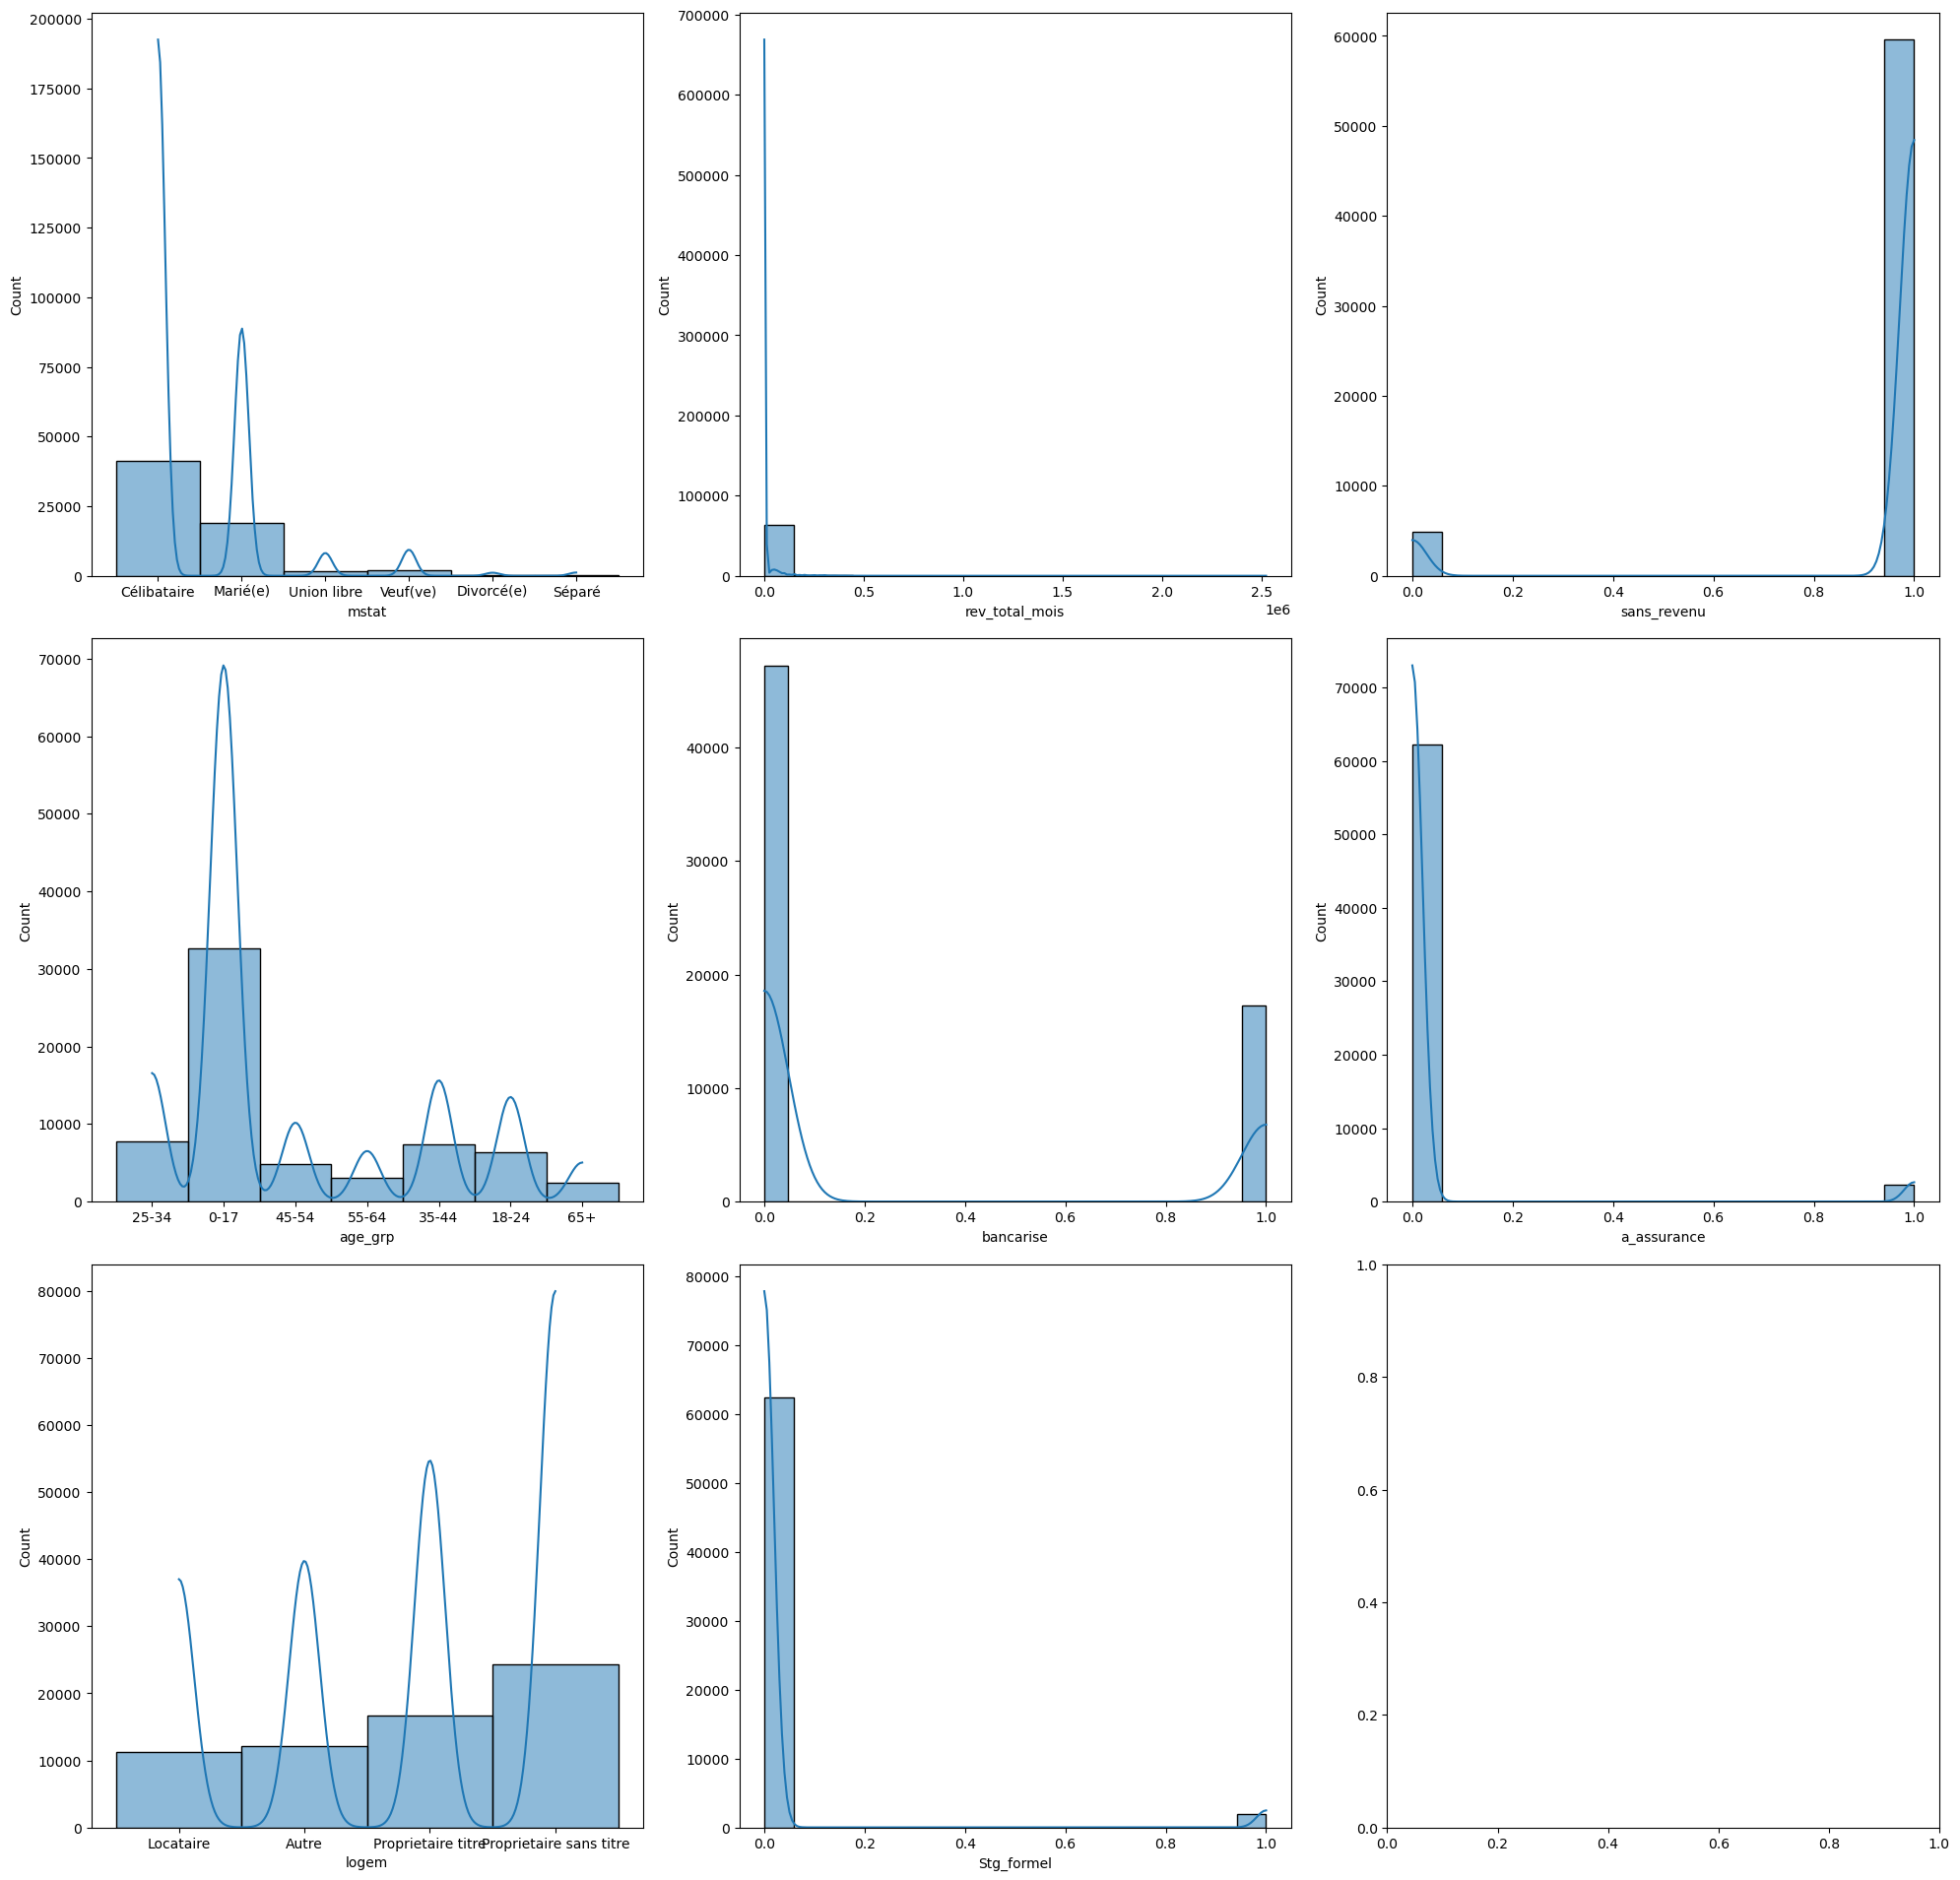

In [233]:
fig, ax = plt.subplots(3, 3, figsize=(20, 20))
ax = ax.flatten()
i = 0
Inf_score.replace([np.inf, -np.inf], np.nan, inplace=True)
for col in Inf_score.columns:
    sns.histplot(data = Inf_score, x=col,kde = True ,ax = ax[i])
    i += 1
plt.tight_layout(rect=[0, 0, 1, 0.96])
print("Differentes catégories")
plt.show()

## **CREATION OF THE TARGET**

In [234]:
def score_inclusion_financiere(row):
    score = 0
       
    #print(f"\n---------------------Data {row.name}------------------\n")

    # Situation Matrimoniale (12 points)   ok
    if row['mstat'] == "Marié(e)":
        score += 12
    elif row['mstat'] in ["Célibataire", "Union libre"]:
        score += 10
    elif row['mstat'] == "Veuf(ve)":
        score += 6
    elif row['mstat'] in ["Divorcé(e)", "Séparé"]:
        score += 8
    
    #print(f"1 - {score}")
    
    # Groupe d'Âge (10 points)  ok
    if row['age_grp'] == "65+":
        score += 3
    elif row['age_grp'] == "55-64":
        score += 5
    elif row['age_grp'] == "18-24":
        score += 6
    elif row['age_grp'] == "45-54":
        score += 7
    elif row['age_grp'] in ["25-34", "35-44"]:
        score += 10
    
    #print(f"2 - {score}")
    
    # Bancarisation (10 points)   ok
    if row['bancarise'] == 1:
        score += 10
    elif row['bancarise'] == 0:
        score += 6

    #print(f"3 - {score}")
    
    # Assurance (5 points)   ok
    if row['a_assurance'] == 1:
        score += 5
    elif row['a_assurance'] == 0:
        score += 2

    #print(f"4 - {score}")
    
    # Logement (20 points)   ok
    if row['logem'] == "Proprietaire titre":
        score += 20
    elif row['logem'] == "Proprietaire sans titre":
        score += 15
    elif row['logem'] == "Locataire":
        score += 10
    #print(f"5 - {score}")

    # Revenu (25 points)  ok
    if (row['rev_total_mois'] >= 50000) and (row['rev_total_mois'] < 300000):
        score += 5
    elif (row['rev_total_mois'] >= 300000) and (row['rev_total_mois'] < 500000):
        score += 10
    elif (row['rev_total_mois'] >= 500000) and (row['rev_total_mois'] < 1000000):
        score += 20
    elif row['rev_total_mois'] >= 1000000:
        score += 25

    #print(f"6 - {score}")
    #print(f"\n---------------------------------------\n")

    return score


In [235]:
Inf_score['Profil_Score'] = Inf_score.apply(score_inclusion_financiere, axis=1)
print("-------------- FIN DE LA CREATION DU TARGET --------------")

-------------- FIN DE LA CREATION DU TARGET --------------


In [236]:
classes = Inf_score['Profil_Score'].unique()
classes

array([47, 28, 40, 41, 39, 37, 44, 42, 38, 32, 31, 52, 57, 54, 18, 33, 21,
       24, 34, 25, 49, 45, 46, 51, 48, 19, 30, 29, 43, 50, 56, 35, 27, 67,
       59, 36, 53, 55, 23, 64, 22, 62, 60, 72, 80, 75, 71, 65, 66, 74, 77,
       82, 73, 79, 61, 69, 68, 17, 26, 20, 70])

In [237]:
Inf_score['Profil_Score'].nunique()

61

In [238]:
Inf_score

,mstat,rev_total_mois,sans_revenu,age_grp,bancarise,a_assurance,logem,Stg_formel,Profil_Score
0,Célibataire,279244.0,0,25-34,1,0,Locataire,1,47
1,Célibataire,0.0,1,0-17,0,0,Locataire,0,28
2,Célibataire,0.0,1,0-17,0,0,Locataire,0,28
3,Célibataire,0.0,1,0-17,0,0,Locataire,0,28
4,Marié(e),0.0,1,25-34,0,0,Locataire,0,40
...,...,...,...,...,...,...,...,...,...
64469,Célibataire,0.0,1,0-17,0,0,Proprietaire titre,0,38
64470,Célibataire,0.0,1,0-17,0,0,Proprietaire titre,0,38
64471,Célibataire,0.0,1,0-17,0,0,Proprietaire titre,0,38
64472,Célibataire,0.0,1,0-17,0,0,Proprietaire titre,0,38


In [239]:
Inf_score = Inf_score[Inf_score['Stg_formel'] == 0]
Inf_score

,mstat,rev_total_mois,sans_revenu,age_grp,bancarise,a_assurance,logem,Stg_formel,Profil_Score
1,Célibataire,0.0,1,0-17,0,0,Locataire,0,28
2,Célibataire,0.0,1,0-17,0,0,Locataire,0,28
3,Célibataire,0.0,1,0-17,0,0,Locataire,0,28
4,Marié(e),0.0,1,25-34,0,0,Locataire,0,40
5,Marié(e),0.0,1,45-54,1,0,Locataire,0,41
...,...,...,...,...,...,...,...,...,...
64469,Célibataire,0.0,1,0-17,0,0,Proprietaire titre,0,38
64470,Célibataire,0.0,1,0-17,0,0,Proprietaire titre,0,38
64471,Célibataire,0.0,1,0-17,0,0,Proprietaire titre,0,38
64472,Célibataire,0.0,1,0-17,0,0,Proprietaire titre,0,38


## **LABELING OF VARIABLES**

In [240]:
label_encoders = {}

# Variables catégorielles à encoder
cat_cols = ['mstat', 'age_grp', 'logem']

for col in cat_cols:
    le = LabelEncoder()
    Inf_score[col] = le.fit_transform(Inf_score[col])
    label_encoders[col] = le
Inf_score

,mstat,rev_total_mois,sans_revenu,age_grp,bancarise,a_assurance,logem,Stg_formel,Profil_Score
1,0,0.0,1,0,0,0,1,0,28
2,0,0.0,1,0,0,0,1,0,28
3,0,0.0,1,0,0,0,1,0,28
4,2,0.0,1,2,0,0,1,0,40
5,2,0.0,1,4,1,0,1,0,41
...,...,...,...,...,...,...,...,...,...
64469,0,0.0,1,0,0,0,3,0,38
64470,0,0.0,1,0,0,0,3,0,38
64471,0,0.0,1,0,0,0,3,0,38
64472,0,0.0,1,0,0,0,3,0,38


In [241]:
# Afficher les mappings pour chaque variable
for col in cat_cols:
    le = label_encoders[col]
    mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    print(f"Mapping '{col}':")
    for k, v in mapping.items():
        print(f"  {k} -> {v}")
    print("-" * 30)

Mapping 'mstat':
  Célibataire -> 0
  Divorcé(e) -> 1
  Marié(e) -> 2
  Séparé -> 3
  Union libre -> 4
  Veuf(ve) -> 5
------------------------------
Mapping 'age_grp':
  0-17 -> 0
  18-24 -> 1
  25-34 -> 2
  35-44 -> 3
  45-54 -> 4
  55-64 -> 5
  65+ -> 6
------------------------------
Mapping 'logem':
  Autre -> 0
  Locataire -> 1
  Proprietaire sans titre -> 2
  Proprietaire titre -> 3
------------------------------


In [242]:
Inf_score

,mstat,rev_total_mois,sans_revenu,age_grp,bancarise,a_assurance,logem,Stg_formel,Profil_Score
1,0,0.0,1,0,0,0,1,0,28
2,0,0.0,1,0,0,0,1,0,28
3,0,0.0,1,0,0,0,1,0,28
4,2,0.0,1,2,0,0,1,0,40
5,2,0.0,1,4,1,0,1,0,41
...,...,...,...,...,...,...,...,...,...
64469,0,0.0,1,0,0,0,3,0,38
64470,0,0.0,1,0,0,0,3,0,38
64471,0,0.0,1,0,0,0,3,0,38
64472,0,0.0,1,0,0,0,3,0,38


### **Correlation Matrix**

In [243]:
Inf_score = Inf_score.drop(['Stg_formel'], axis=1)


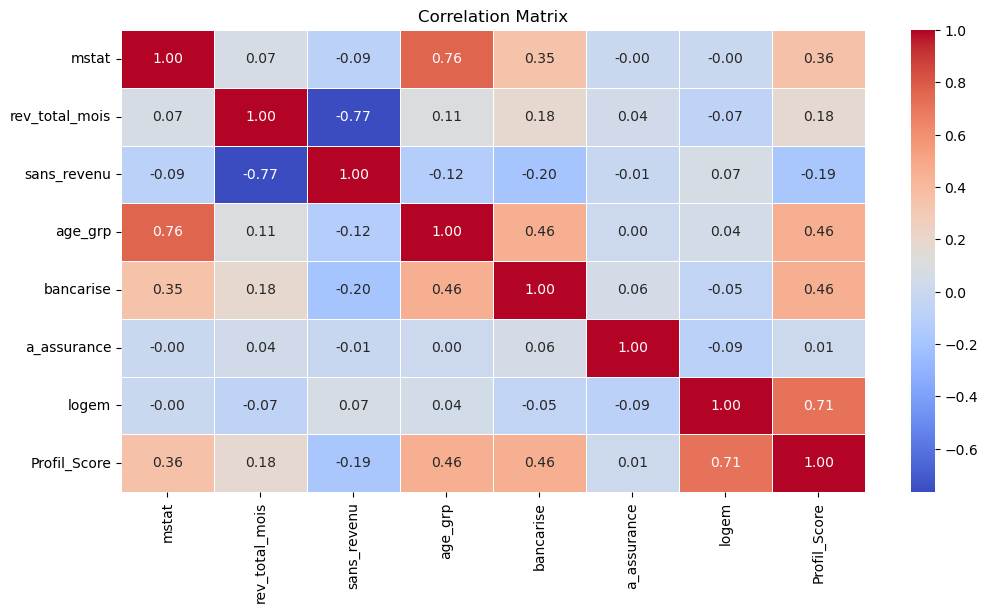

In [244]:
df_subset = Inf_score
corr_matrix = df_subset.corr()
plt.figure(figsize = (12,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

#### Les méthodes de filtrage comme la corrélation ou le seuil de variance sont excellentes quand nous avons beaucoup de caractéristiques et voulons supprimer rapidement celles qui ne sont pas pertinentes et voir le comportement des caractérisques par rapport à la variable cible. Cependant, si nous voulons maximiser les performances du modèle et avoir les ressources de calcul, nous pourrions vouloir explorer des méthodes d'emballage comme RFE ou des méthodes intégrées comme Lasso. 

#### La matrice de correlation permet aussi d'observer les variables qui sont corrélées entre elles et celles qui ont un impact sur la variable cible. Ainsi l'on à une idée de comment maximiser les performances du modèle et optimiser à l'avance les erreurs possibles du modèle.

#### OBSERVATION : Les variables ne sont pas corrélées entre elles et à la variable cible. Pas de problème à ce niveau. 

In [245]:
#Inf_score = Inf_score.drop(['Stg_formel'], axis=1)

## **SEPARATE THE FEATURES FROM THE TARGET**

In [246]:
# Separation des caractérisques et de la cible

X = Inf_score.drop(columns=['Profil_Score'])
y = Inf_score['Profil_Score']

In [247]:
X

,mstat,rev_total_mois,sans_revenu,age_grp,bancarise,a_assurance,logem
1,0,0.0,1,0,0,0,1
2,0,0.0,1,0,0,0,1
3,0,0.0,1,0,0,0,1
4,2,0.0,1,2,0,0,1
5,2,0.0,1,4,1,0,1
...,...,...,...,...,...,...,...
64469,0,0.0,1,0,0,0,3
64470,0,0.0,1,0,0,0,3
64471,0,0.0,1,0,0,0,3
64472,0,0.0,1,0,0,0,3


In [248]:
y

1        28
2        28
3        28
4        40
5        41
         ..
64469    38
64470    38
64471    38
64472    38
64473    54
Name: Profil_Score, Length: 62495, dtype: int64

## **SEPARATION OF TRAINING, VALIDATION AND TESTING**

In [249]:
features = ['mstat', 'sans_revenu', 'age_grp', 'bancarise', 'a_assurance', 'logem', 'rev_total_mois']
target = 'Profil_Score'

In [250]:
# Données d'entrainement, validation et de test

# Séparation initiale train+val et test
#X_train_val, X_test_n, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Séparation train et validation
#X_train_n, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)  
# 0.25 * 0.8 = 0.2 donc validation = 20%

X_train_n, X_test_n, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"X_train :{X_train_n.shape}")
print(f"y_train :{y_train.shape}")
#print(f"X_val :{X_val.shape}")
#print(f"y_val :{y_val.shape}")
print(f"X_test :{X_test_n.shape}")
print(f"y_test :{y_test.shape}")

X_train :(49996, 7)
y_train :(49996,)
X_test :(12499, 7)
y_test :(12499,)


In [251]:
X_train_n

,mstat,rev_total_mois,sans_revenu,age_grp,bancarise,a_assurance,logem
17347,0,0.0,1,0,0,0,1
41092,0,0.0,1,0,0,0,2
1596,0,0.0,1,0,0,0,1
23616,0,0.0,1,0,0,0,2
3931,0,0.0,1,2,1,0,1
...,...,...,...,...,...,...,...
56140,2,0.0,1,4,1,0,2
39684,0,0.0,1,0,0,0,0
958,2,150000.0,0,2,1,0,1
16656,0,0.0,1,0,0,0,3


## **MODEL TRAINING PROCESS**

### **Choice The Best Model**

#### SETS OF TESTS MODELS

In [252]:
dat = pd.DataFrame([{'mstat':0, 'rev_total_mois':279244.0, 'age_grp':2, 'bancarise':1, 'a_assurance':0, 'logem':1},
                    {'mstat':0, 'rev_total_mois':380000.00,   'age_grp':3, 'bancarise':1, 'a_assurance':1, 'logem':1},
                    {'mstat':2, 'rev_total_mois':0.00,    'age_grp':2, 'bancarise':1, 'a_assurance':0, 'logem':1},
                    {'mstat':2, 'rev_total_mois':200000.00,   'age_grp':3, 'bancarise':1, 'a_assurance':1, 'logem':1},
                    {'mstat':0, 'rev_total_mois':0.00,    'age_grp':0, 'bancarise':0, 'a_assurance':1, 'logem':1},
                    {'mstat':2, 'rev_total_mois':0.00,   'age_grp':4, 'bancarise':1, 'a_assurance':1, 'logem':1},
                    {'mstat':2, 'rev_total_mois':316733.34,   'age_grp':4, 'bancarise':1, 'a_assurance':1, 'logem':1}
    ])
dat["sans_revenu"] = (dat["rev_total_mois"] == 0).astype(int)

dat = dat[['mstat', 'rev_total_mois', 'sans_revenu', 'age_grp', 'bancarise', 'a_assurance',	'logem']]
dat
# dat['Profil_Score'] = [52, 75, 44, 70, 33, 62, 75]

,mstat,rev_total_mois,sans_revenu,age_grp,bancarise,a_assurance,logem
0,0,279244.00,0,2,1,0,1
1,0,380000.00,0,3,1,1,1
2,2,0.00,1,2,1,0,1
3,2,200000.00,0,3,1,1,1
4,0,0.00,1,0,0,1,1
5,2,0.00,1,4,1,1,1
6,2,316733.34,0,4,1,1,1


In [253]:
dat['Profil_Score'] = [52, 75, 44, 70, 33, 62, 75]
dat_p = dat.drop(columns=['Profil_Score'])
y_d = dat['Profil_Score']
y_d

0    52
1    75
2    44
3    70
4    33
5    62
6    75
Name: Profil_Score, dtype: int64

In [254]:
# Test intérieur du modèle extrait
datas = pd.DataFrame([
    {'mstat':0, 'rev_total_mois':0,        'age_grp':0, 'bancarise':0, 'a_assurance':0, 'logem':1, 'Profil_Score':28},
    {'mstat':1, 'rev_total_mois':50000,    'age_grp':1, 'bancarise':1, 'a_assurance':1, 'logem':2, 'Profil_Score':65},
    {'mstat':2, 'rev_total_mois':120000,   'age_grp':2, 'bancarise':1, 'a_assurance':0, 'logem':3, 'Profil_Score':78},
    {'mstat':3, 'rev_total_mois':250000,   'age_grp':3, 'bancarise':0, 'a_assurance':1, 'logem':0, 'Profil_Score':49},
    {'mstat':4, 'rev_total_mois':400000,   'age_grp':4, 'bancarise':1, 'a_assurance':1, 'logem':2, 'Profil_Score':85},
    {'mstat':5, 'rev_total_mois':30000,    'age_grp':5, 'bancarise':0, 'a_assurance':1, 'logem':3, 'Profil_Score':62},
    {'mstat':2, 'rev_total_mois':900000,   'age_grp':6, 'bancarise':1, 'a_assurance':0, 'logem':2, 'Profil_Score':91},
    {'mstat':0, 'rev_total_mois':150000,   'age_grp':1, 'bancarise':0, 'a_assurance':0, 'logem':0, 'Profil_Score':33},
    {'mstat':4, 'rev_total_mois':80000,    'age_grp':5, 'bancarise':1, 'a_assurance':1, 'logem':1, 'Profil_Score':72},
    {'mstat':1, 'rev_total_mois':1000000,  'age_grp':0, 'bancarise':0, 'a_assurance':0, 'logem':2, 'Profil_Score':38},
    {'mstat':5, 'rev_total_mois':290000,   'age_grp':3, 'bancarise':1, 'a_assurance':0, 'logem':3, 'Profil_Score':70},
    {'mstat':1, 'rev_total_mois':750000,   'age_grp':4, 'bancarise':1, 'a_assurance':1, 'logem':0, 'Profil_Score':82},
    {'mstat':2, 'rev_total_mois':330000,   'age_grp':2, 'bancarise':0, 'a_assurance':1, 'logem':2, 'Profil_Score':55},
    {'mstat':0, 'rev_total_mois':200000,   'age_grp':1, 'bancarise':0, 'a_assurance':1, 'logem':1, 'Profil_Score':60},
    {'mstat':5, 'rev_total_mois':50000,    'age_grp':6, 'bancarise':0, 'a_assurance':0, 'logem':3, 'Profil_Score':41},
    {'mstat':4, 'rev_total_mois':870000,   'age_grp':0, 'bancarise':1, 'a_assurance':1, 'logem':1, 'Profil_Score':78},
    {'mstat':3, 'rev_total_mois':20000,    'age_grp':1, 'bancarise':1, 'a_assurance':0, 'logem':0, 'Profil_Score':44},
    {'mstat':2, 'rev_total_mois':450000,   'age_grp':3, 'bancarise':1, 'a_assurance':1, 'logem':3, 'Profil_Score':80},
    {'mstat':0, 'rev_total_mois':35000,    'age_grp':5, 'bancarise':0, 'a_assurance':0, 'logem':2, 'Profil_Score':39},
    {'mstat':5, 'rev_total_mois':800000,   'age_grp':6, 'bancarise':1, 'a_assurance':1, 'logem':2, 'Profil_Score':95}
])

# Pour ton DataFrame "datas"
datas["sans_revenu"] = (datas["rev_total_mois"] == 0).astype(int)
datas = datas[['mstat', 'rev_total_mois', 'sans_revenu', 'age_grp', 'bancarise', 'a_assurance',	'logem', 'Profil_Score']]
datas

,mstat,rev_total_mois,sans_revenu,age_grp,bancarise,a_assurance,logem,Profil_Score
0,0,0,1,0,0,0,1,28
1,1,50000,0,1,1,1,2,65
2,2,120000,0,2,1,0,3,78
3,3,250000,0,3,0,1,0,49
4,4,400000,0,4,1,1,2,85
5,5,30000,0,5,0,1,3,62
6,2,900000,0,6,1,0,2,91
7,0,150000,0,1,0,0,0,33
8,4,80000,0,5,1,1,1,72
9,1,1000000,0,0,0,0,2,38


In [255]:
datas_p = datas.drop(columns=['Profil_Score'])
y_datas = datas['Profil_Score']
y_datas

0     28
1     65
2     78
3     49
4     85
5     62
6     91
7     33
8     72
9     38
10    70
11    82
12    55
13    60
14    41
15    78
16    44
17    80
18    39
19    95
Name: Profil_Score, dtype: int64

## **Regressor Model**

#### **Search best model**

In [27]:
models = {
    "Random Regressor" : RandomForestRegressor(n_estimators=10, random_state=42, max_depth=10),
    "XGBRegressor" : XGBRegressor(n_estimators=100, learning_rate=0.13, random_state=42)
}

results = {}


🏆 Random Regressor
          - RMSE CV: 0.5103 ± 0.0085
          - R2 CV: 0.9970 ± 0.0001
          - R2 (test): 0.9967
          - RMSE (test): 0.5254



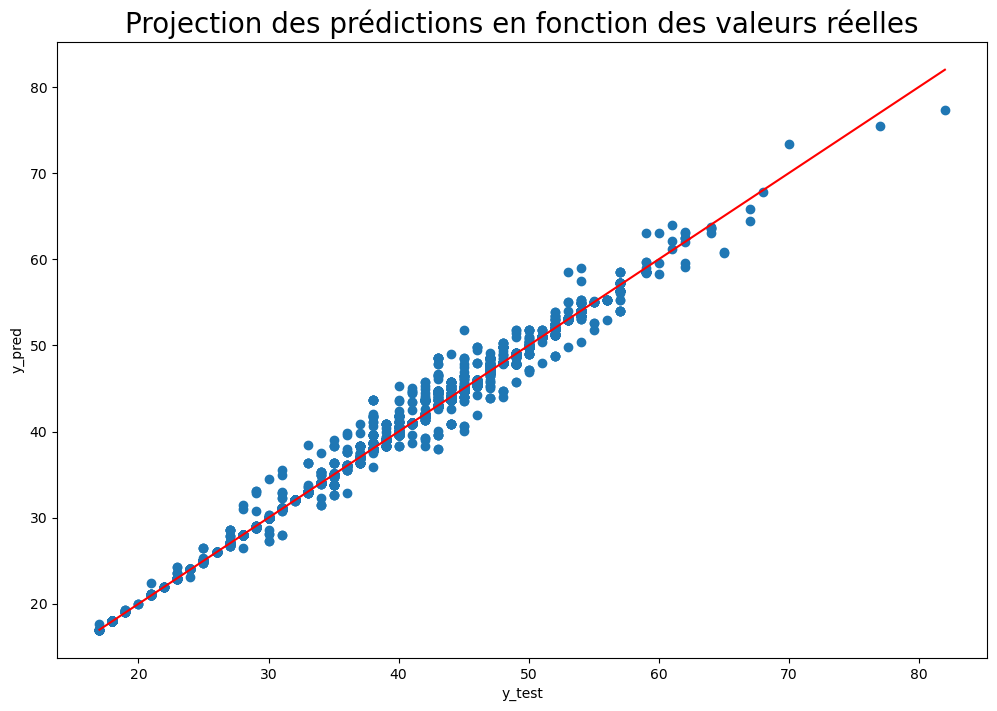

          Importance des variables :
          variable  importance
5  rev_total_mois    0.518858
2       bancarise    0.395682
3     a_assurance    0.036358
1         age_grp    0.024519
0           mstat    0.021880
4           logem    0.002703


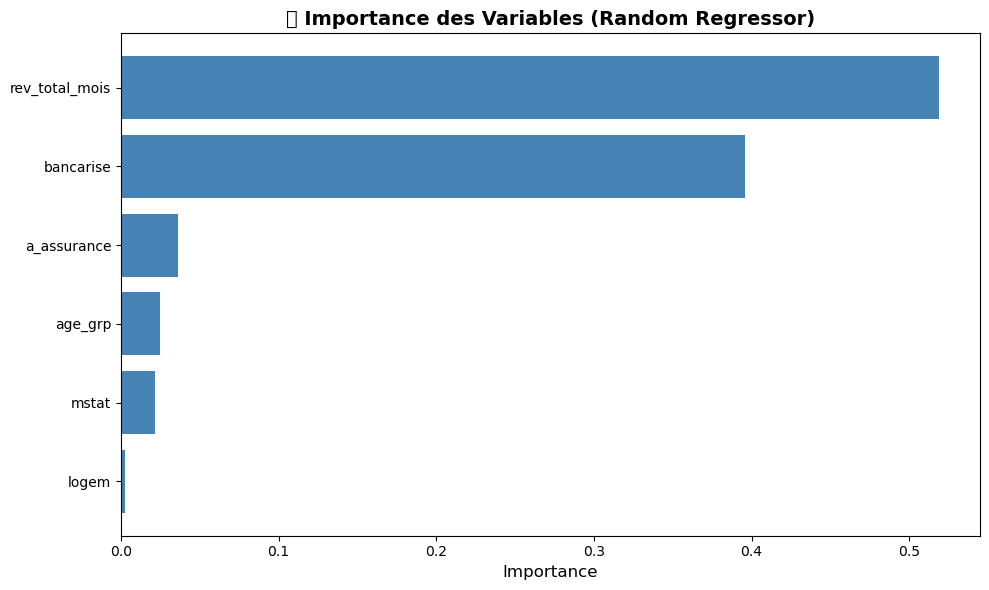


🏆 XGBRegressor
          - RMSE CV: 0.1263 ± 0.0186
          - R2 CV: 0.9998 ± 0.0001
          - R2 (test): 0.9998
          - RMSE (test): 0.1386



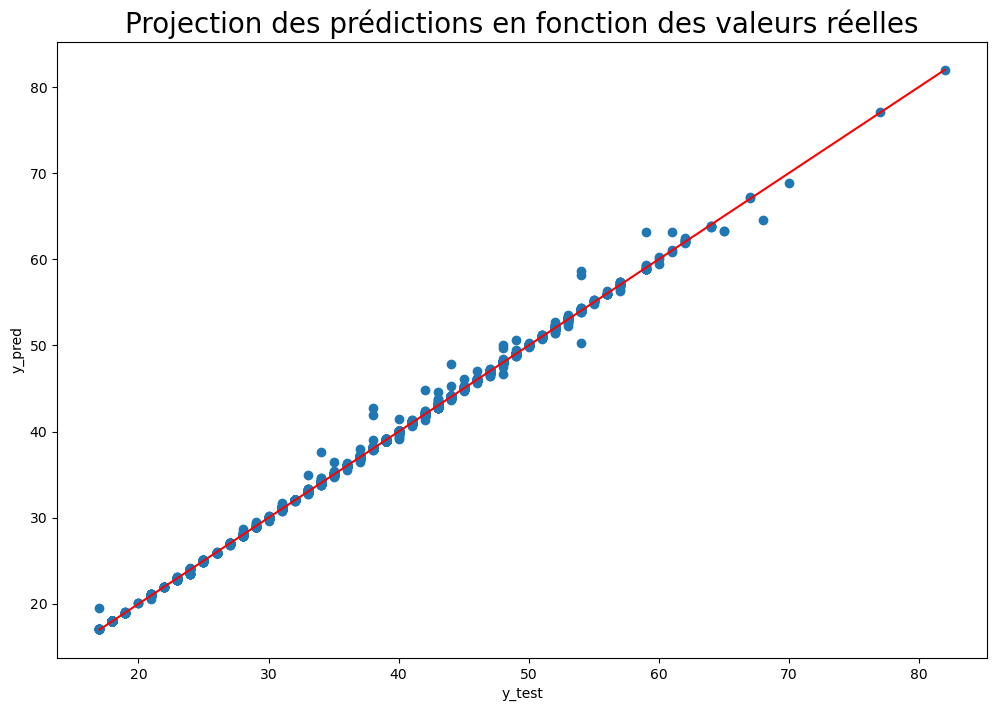

          Importance des variables :
          variable  importance
5  rev_total_mois    0.559273
2       bancarise    0.310892
3     a_assurance    0.069854
0           mstat    0.029774
1         age_grp    0.020915
4           logem    0.009292


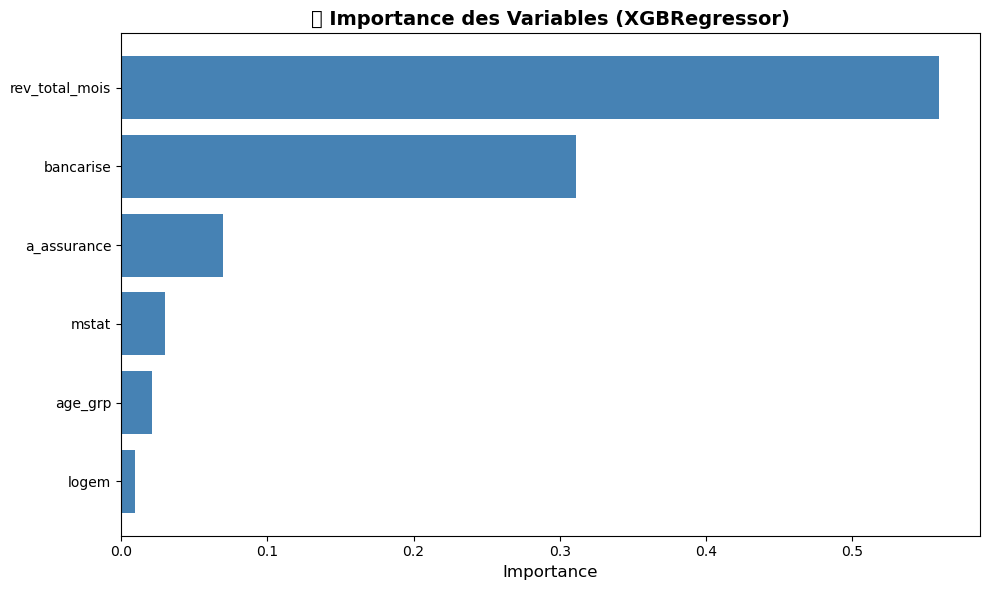

In [28]:
for name, model in models.items():
    # Validation croisée sur le train set
    rmse_scores = -cross_val_score(model, X_train_n, y_train, cv=5, scoring='neg_root_mean_squared_error')
    r2_scores = cross_val_score(model, X_train_n, y_train, cv=5, scoring='r2')
    print(f"\n🏆 {name}")
    print(f"          - RMSE CV: {rmse_scores.mean():.4f} ± {rmse_scores.std():.4f}")
    print(f"          - R2 CV: {r2_scores.mean():.4f} ± {r2_scores.std():.4f}")

    # Fit sur tout le train set et prédiction sur test
    model.fit(X_train_n, y_train)
    y_pred = model.predict(X_test_n)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    print(f"          - R2 (test): {r2:.4f}")
    print(f"          - RMSE (test): {rmse:.4f}\n")
    results[name] = {'rmse_cv': rmse_scores.mean(), 'r2_cv': r2_scores.mean(), 'rmse_test': rmse, 'r2_test': r2}

    # Predictions
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(1, 1, 1)
    ax.scatter(y_test, y_pred)
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='r')
    ax.set(xlabel='y_test', ylabel='y_pred')
    plt.title("Projection des prédictions en fonction des valeurs réelles", fontsize=20)
    plt.show()
        
    # Importance des variables
    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
        importance_df = pd.DataFrame({'variable': features, 'importance': importances}).sort_values(by='importance', ascending=False)
        print("          Importance des variables :\n", importance_df)
        plt.figure(figsize=(10, 6))
        plt.barh(importance_df['variable'], importance_df['importance'], color='steelblue')
        plt.xlabel('Importance', fontsize=12)
        plt.title(f'📊 Importance des Variables ({name})', fontsize=14, fontweight='bold')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()

### **Vizualisation Models**

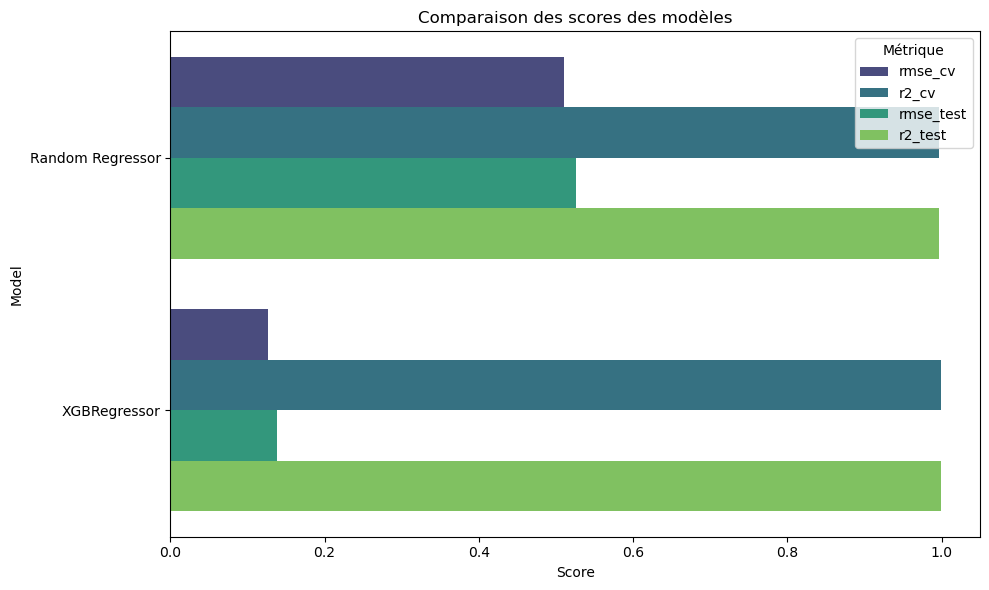

In [29]:
results_long = []
for model, scores in results.items():
    for metric, value in scores.items():
        results_long.append({'Model': model, 'Metric': metric, 'Score': value})

results_df = pd.DataFrame(results_long)

# Visualisation : un barplot par métrique
plt.figure(figsize=(10, 6))
sns.barplot(x="Score", y="Model", hue="Metric", data=results_df, palette="viridis")
plt.xlabel("Score")
plt.ylabel("Model")
plt.title("Comparaison des scores des modèles")
plt.legend(title="Métrique")
plt.tight_layout()
plt.show()

### **Search for the Hyperparameter of XGBRegressor**

In [30]:
param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.7, 1.0],
    'colsample_bytree': [0.7, 1.0]
}

In [31]:
grid_search_xgb = GridSearchCV(
    estimator=XGBRegressor(random_state=42),
    param_grid=param_grid_xgb,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)
grid_search_xgb.fit(X_train_n, y_train)
print("Meilleurs paramètres XGB :", grid_search_xgb.best_params_)
print("Meilleur score RMSE CV XGB :", -grid_search_xgb.best_score_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Meilleurs paramètres XGB : {'colsample_bytree': 0.7, 'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1.0}
Meilleur score RMSE CV XGB : 0.08988654017448425


### **Retraining the model with the hyperparameter**

In [32]:
best_params_xgb = grid_search_xgb.best_params_

In [33]:
# XGBRegressor
best_xgb = XGBRegressor(**best_params_xgb, random_state=2)
best_xgb.fit(X_train_n, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.3, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=None, num_parallel_tree=None, ...)

          Importance des variables :
          variable  importance
5  rev_total_mois    0.421425
3     a_assurance    0.226600
2       bancarise    0.220358
0           mstat    0.102287
1         age_grp    0.019773
4           logem    0.009556


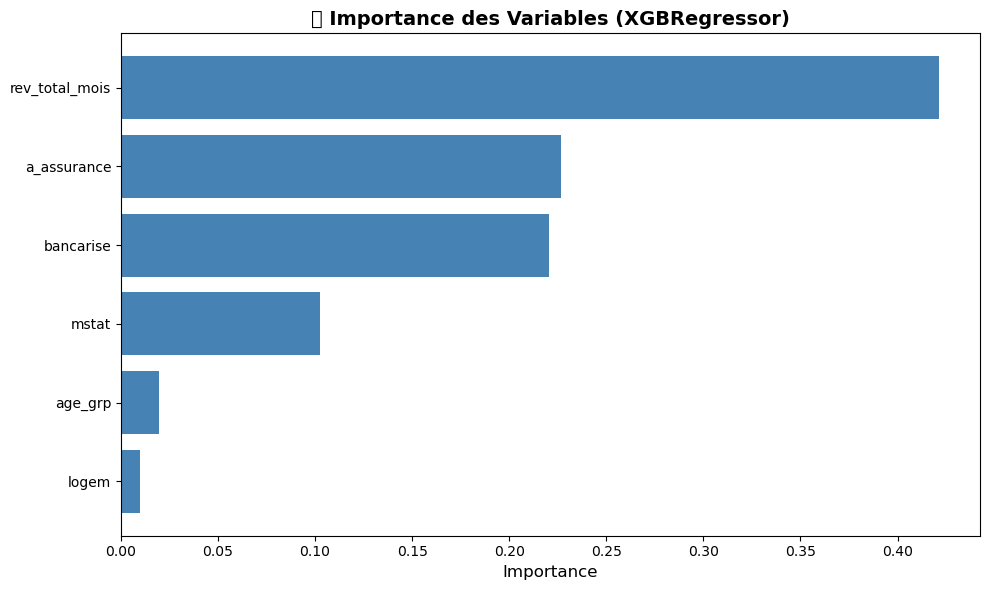

In [34]:

if hasattr(best_xgb, "feature_importances_"):
        importances = best_xgb.feature_importances_
        import_df = pd.DataFrame({'variable': features, 'importance': importances}).sort_values(by='importance', ascending=False)
        print("          Importance des variables :\n", import_df)
        plt.figure(figsize=(10, 6))
        plt.barh(import_df['variable'], import_df['importance'], color='steelblue')
        plt.xlabel('Importance', fontsize=12)
        plt.title(f'📊 Importance des Variables ({name})', fontsize=14, fontweight='bold')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()

In [35]:
# Prédictions
y_pred_xgb = best_xgb.predict(X_test_n)

# Scores
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBRegressor - RMSE: {rmse_xgb:.4f}, R2: {r2_xgb:.4f}")

XGBRegressor - RMSE: 0.1091, R2: 0.9999


### **Evaluation with set test**

#### 1er test

In [36]:
xgb_dat = best_xgb.predict(dat_p)
xgb_dat

array([47.03716 , 54.875824, 43.976704, 52.00833 , 31.003616, 44.02231 ,
       53.980618], dtype=float32)

In [37]:
rms = np.sqrt(mean_squared_error(y_d, xgb_dat))
r = r2_score(y_d, xgb_dat)

print(f"RMSE sur test : {rms}")
print(f"R2 sur test : {r}")

RMSE sur test : 14.746962412328344
R2 sur test : 0.04343158006668091


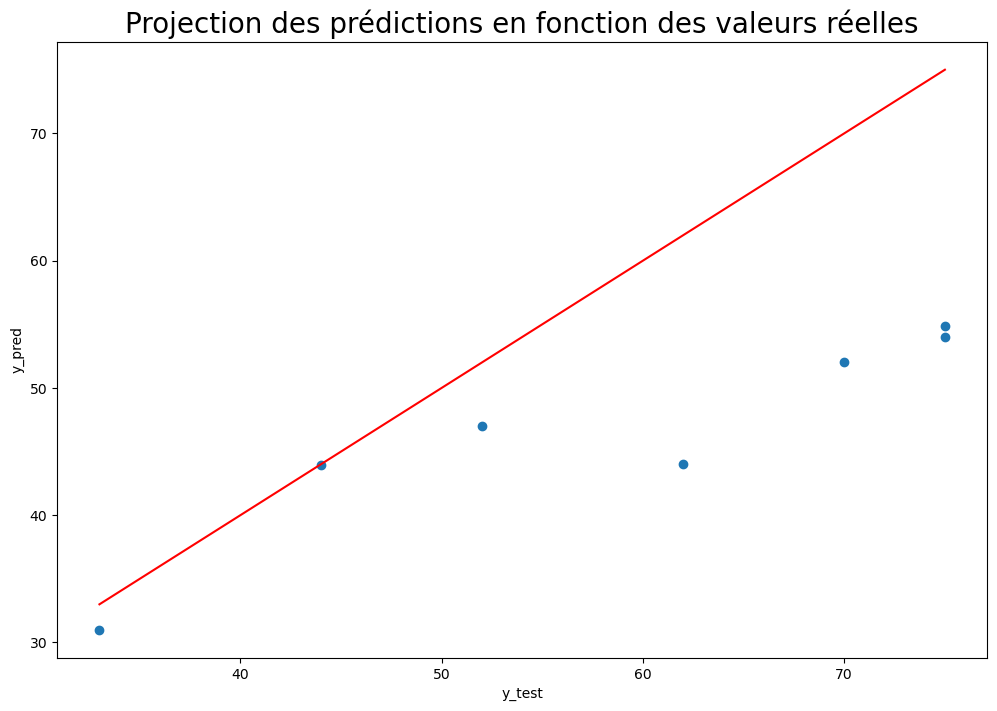

In [38]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(y_d, xgb_dat)
ax.plot([y_d.min(), y_d.max()], [y_d.min(), y_d.max()], color='r')
ax.set(xlabel='y_test', ylabel='y_pred')
plt.title("Projection des prédictions en fonction des valeurs réelles", fontsize=20)
plt.show()

#### 2e test

In [39]:
xgb_data = best_xgb.predict(datas_p)
xgb_data

array([28.000233, 49.86067 , 59.007336, 34.08674 , 57.50621 , 42.63686 ,
       62.760845, 29.110518, 44.657887, 46.661392, 55.151432, 50.964417,
       55.47525 , 41.596817, 40.503674, 55.856583, 25.795734, 66.75323 ,
       37.623867, 53.161118], dtype=float32)

In [40]:
rms_data = np.sqrt(mean_squared_error(y_datas, xgb_data))
r_data = r2_score(y_datas, xgb_data)

print(f"RMSE sur test : {rms_data}")
print(f"R2 sur test : {r_data}")

RMSE sur test : 19.812597810040508
R2 sur test : 0.013194143772125244


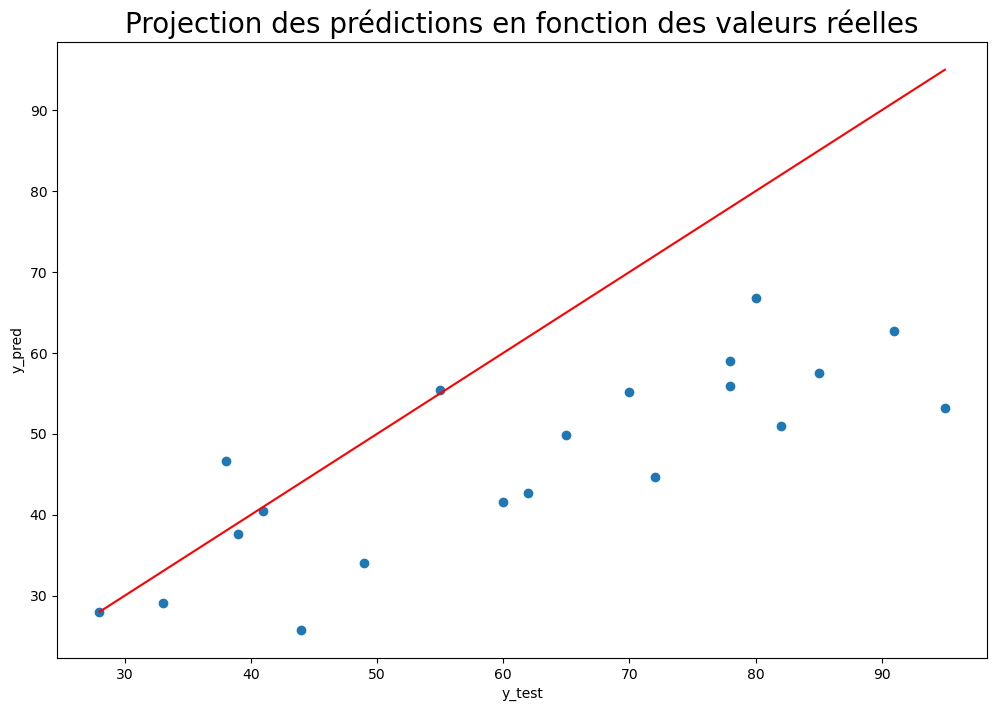

In [41]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(y_datas, xgb_data)
ax.plot([y_datas.min(), y_datas.max()], [y_datas.min(), y_datas.max()], color='r')
ax.set(xlabel='y_test', ylabel='y_pred')
plt.title("Projection des prédictions en fonction des valeurs réelles", fontsize=20)
plt.show()

## **Ensemble Learning Algorithm**

### **Boosting with GradientBoostingRegressor**

In [256]:
from sklearn.ensemble import GradientBoostingRegressor

boosting1 = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)
boosting1.fit(X_train_n, y_train)
y_pred_boost = boosting1.predict(X_test_n)
print("Boosting RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_boost)))
print("Boosting R2:", r2_score(y_test, y_pred_boost))

Boosting RMSE: 0.27412413521604245
Boosting R2: 0.9990995806210808


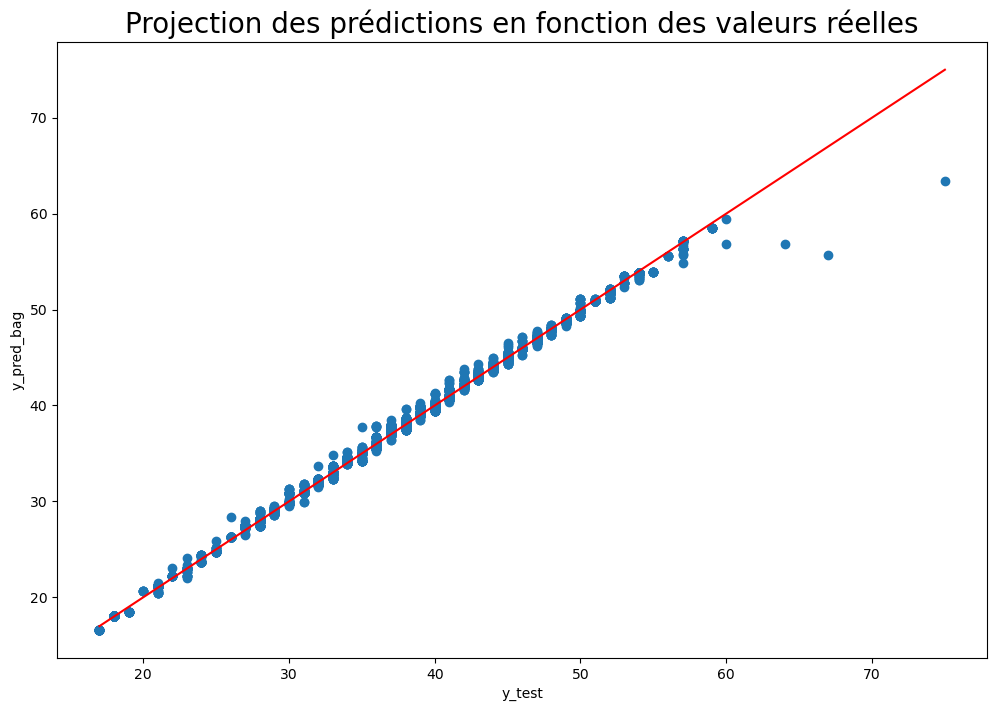

In [257]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(y_test, y_pred_boost)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='r')
ax.set(xlabel='y_test', ylabel='y_pred_bag')
plt.title("Projection des prédictions en fonction des valeurs réelles", fontsize=20)
plt.show()

          Importance des variables :
          variable  importance
6  rev_total_mois    0.532323
3       bancarise    0.338186
4     a_assurance    0.083278
0           mstat    0.031639
1     sans_revenu    0.011977
5           logem    0.002598
2         age_grp    0.000000


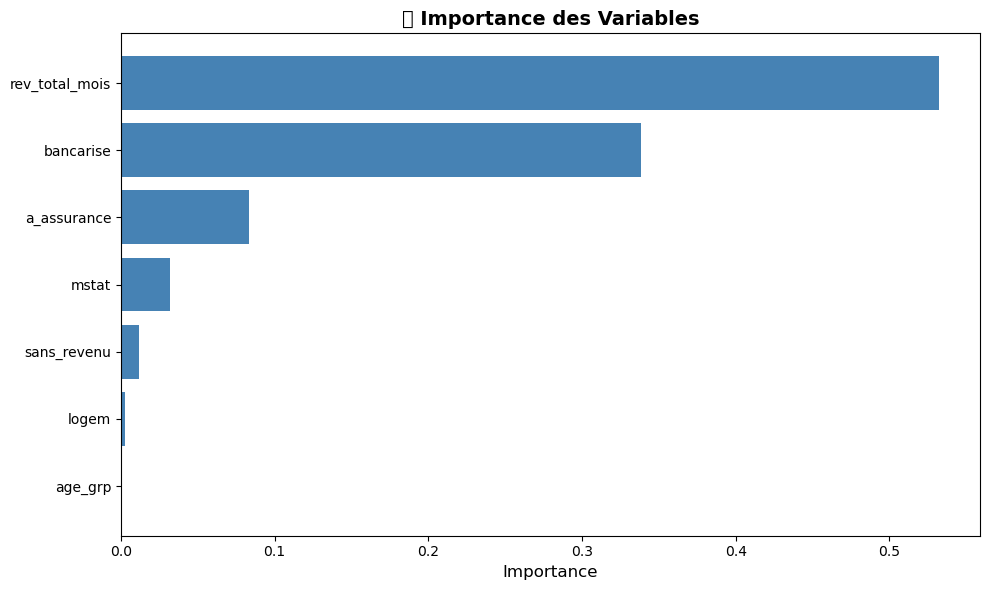

In [258]:
if hasattr(boosting1, "feature_importances_"):
        importances = boosting1.feature_importances_
        import_df = pd.DataFrame({'variable': features, 'importance': importances}).sort_values(by='importance', ascending=False)
        print("          Importance des variables :\n", import_df)
        plt.figure(figsize=(10, 6))
        plt.barh(import_df['variable'], import_df['importance'], color='steelblue')
        plt.xlabel('Importance', fontsize=12)
        plt.title(f'📊 Importance des Variables', fontsize=14, fontweight='bold')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()

### **Search for the Hyperparameter of the Best Model**

In [45]:
param_grid_gb = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.7, 0.9, 1.0],
    'max_features': ['sqrt', 'log2', None]
}

grid_search_gb = GridSearchCV(
    estimator=GradientBoostingRegressor(random_state=42),
    param_grid=param_grid_gb,
    cv=5,
    n_jobs=-1,
    verbose=2,
    scoring='neg_root_mean_squared_error'
)

grid_search_gb.fit(X_train_n, y_train)

print("🧠 Meilleurs paramètres GB:", grid_search_gb.best_params_)
print("📉 Score RMSE (CV):", -grid_search_gb.best_score_)

Fitting 5 folds for each of 2187 candidates, totalling 10935 fits
[CV] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.9; total time=   1.9s
[CV] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   2.0s
[CV] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=0.7; total time=   4.1s
[CV] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=0.9; total time=   5.3s
[CV] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=0.9; total time=  12.6s
[CV] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100, subsample=0.7; total time=   2.5s
[CV] END l

### **Retraining the model with the hyperparameter**

In [46]:
# Évaluation sur le test set avec meilleur modèle
best_params_boost = grid_search_gb.best_params_

In [47]:
# GradientBoostingRegressor
best_boost = GradientBoostingRegressor(**best_params_boost, random_state=42)
best_boost.fit(X_train_n, y_train)

GradientBoostingRegressor(max_depth=5, max_features='sqrt', min_samples_leaf=2,
                          n_estimators=500, random_state=42, subsample=0.9)

#### Features Importances and Performances of model

          Importance des variables :
          variable  importance
5  rev_total_mois    0.515675
2       bancarise    0.198645
0           mstat    0.154481
3     a_assurance    0.090192
1         age_grp    0.035763
4           logem    0.005246


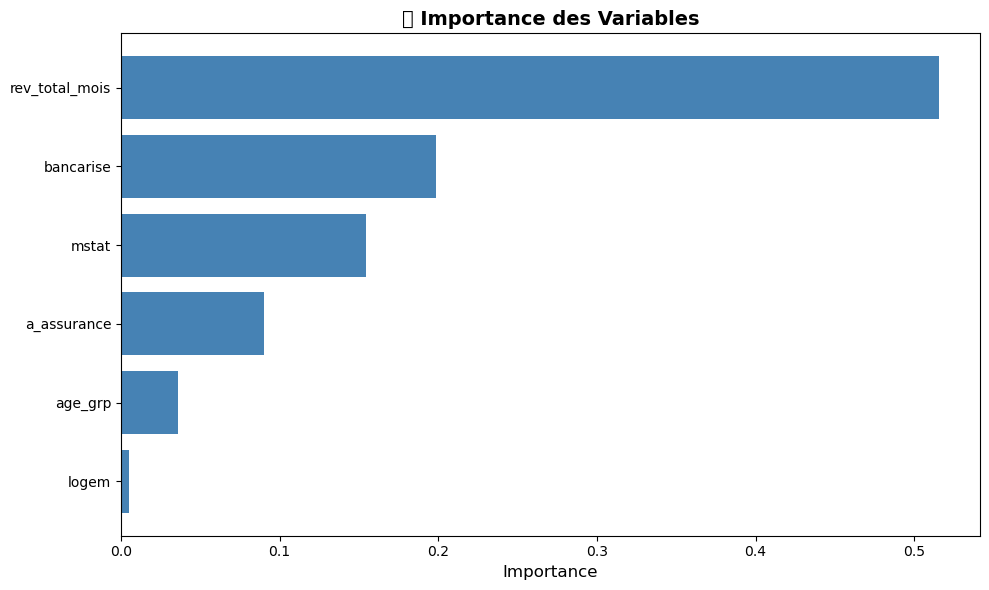

In [48]:
if hasattr(best_boost, "feature_importances_"):
        importances = best_boost.feature_importances_
        import_df = pd.DataFrame({'variable': features, 'importance': importances}).sort_values(by='importance', ascending=False)
        print("          Importance des variables :\n", import_df)
        plt.figure(figsize=(10, 6))
        plt.barh(import_df['variable'], import_df['importance'], color='steelblue')
        plt.xlabel('Importance', fontsize=12)
        plt.title(f'📊 Importance des Variables', fontsize=14, fontweight='bold')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()

In [169]:
# Prédictions
y_pred_rboost = boosting1.predict(X_test_n)

# Scores
rmse_rboost = np.sqrt(mean_squared_error(y_test, y_pred_rboost))
r2_rboost = r2_score(y_test, y_pred_rboost)

print(f"GradientBoostingR - RMSE: {rmse_rboost}, R2: {r2_rboost}")

GradientBoostingR - RMSE: 0.22112588429300026, R2: 0.9994237071875156


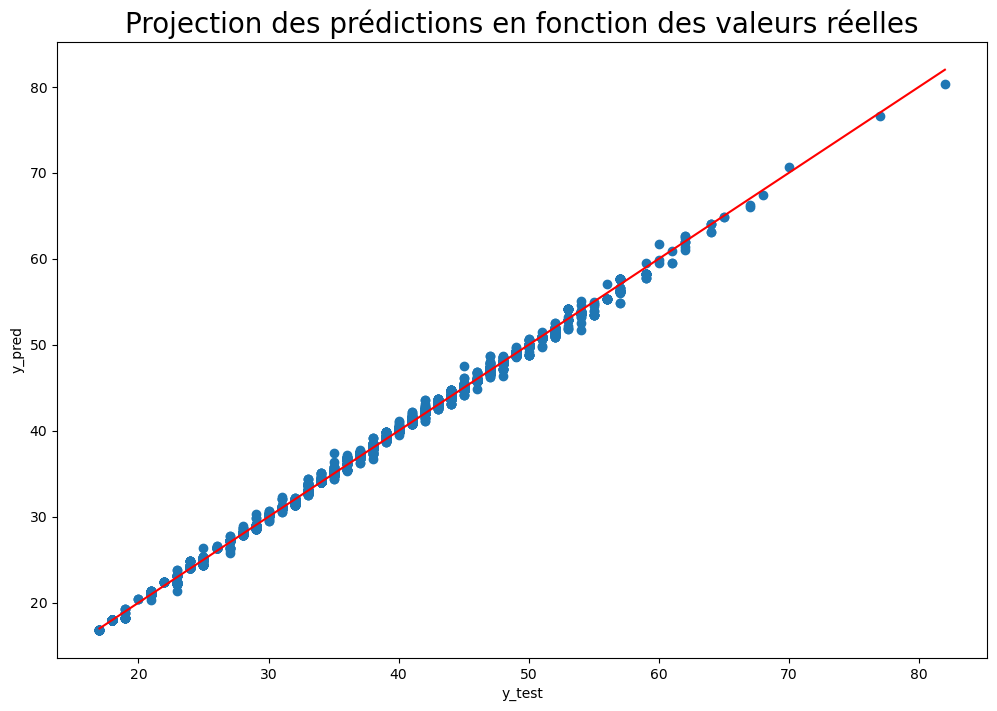

In [170]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(y_test, y_pred_rboost)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='r')
ax.set(xlabel='y_test', ylabel='y_pred')
plt.title("Projection des prédictions en fonction des valeurs réelles", fontsize=20)
plt.show()

### **Evaluation with set test**

#### 1er test

In [259]:
pred_dat = boosting1.predict(dat_p)
pred_dat

array([47.12270201, 54.21467919, 43.79477648, 51.50172839, 30.9157135 ,
       43.89421915, 53.23878946])

In [260]:
rms = np.sqrt(mean_squared_error(y_d, pred_dat))
r = r2_score(y_d, pred_dat)

print(f"RMSE sur test : {rms}")
print(f"R2 sur test : {r}")

RMSE sur test : 15.1363309414067
R2 sur test : -0.007748402515395325


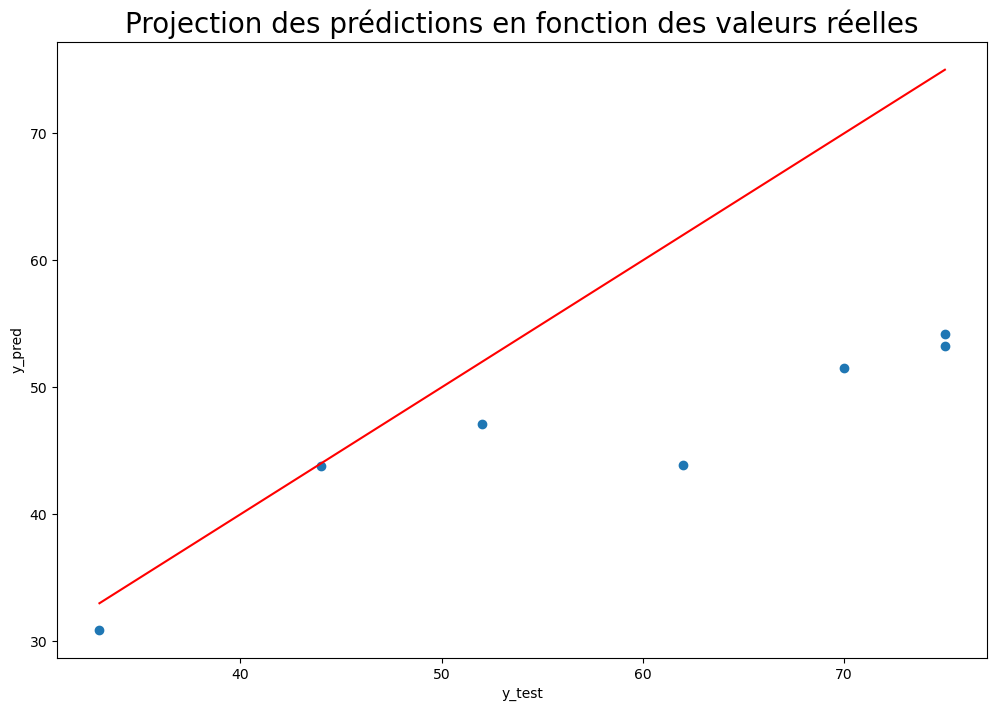

In [261]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(y_d, pred_dat)
ax.plot([y_d.min(), y_d.max()], [y_d.min(), y_d.max()], color='r')
ax.set(xlabel='y_test', ylabel='y_pred')
plt.title("Projection des prédictions en fonction des valeurs réelles", fontsize=20)
plt.show()

#### 2e test

In [262]:
pred_data = boosting1.predict(datas_p)
pred_data

array([28.12104389, 49.86034428, 58.48382099, 34.30149302, 55.19113267,
       42.39922163, 61.34254566, 28.86252339, 45.30467354, 53.01079012,
       53.2372663 , 51.57275463, 55.52070092, 42.02504166, 41.69872932,
       51.74126082, 27.38791327, 64.54022465, 38.55015642, 57.93897453])

In [263]:
rms_data = np.sqrt(mean_squared_error(y_datas, pred_data))
r_data = r2_score(y_datas, pred_data)

print(f"RMSE sur test : {rms_data}")
print(f"R2 sur test : {r_data}")

RMSE sur test : 20.052970177286586
R2 sur test : -0.010895548329560967


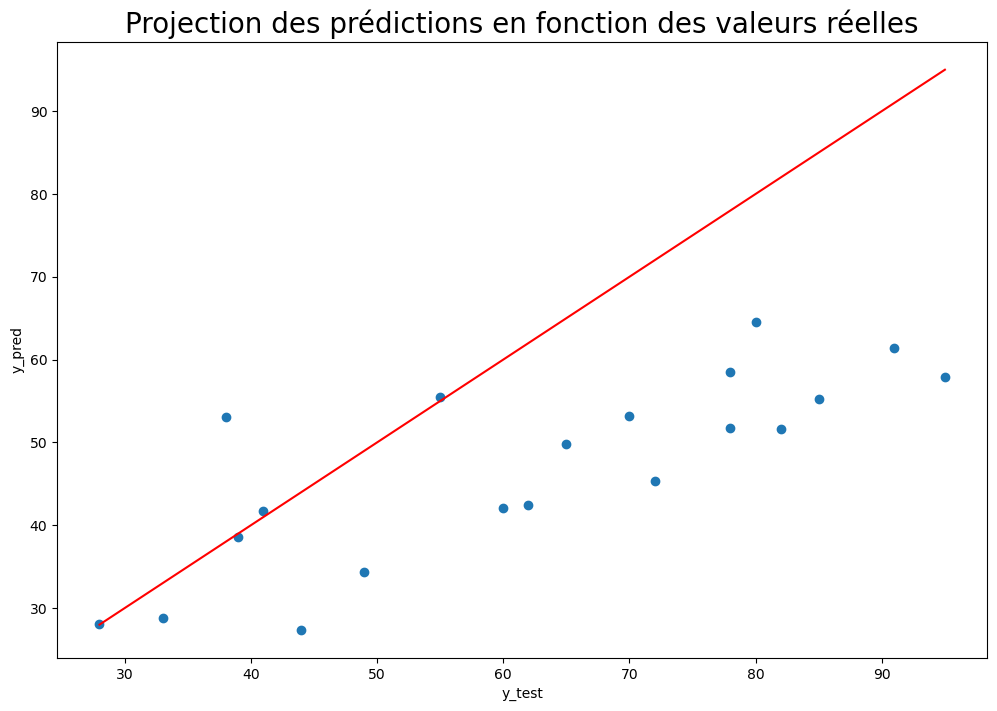

In [264]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(y_datas, pred_data)
ax.plot([y_datas.min(), y_datas.max()], [y_datas.min(), y_datas.max()], color='r')
ax.set(xlabel='y_test', ylabel='y_pred')
plt.title("Projection des prédictions en fonction des valeurs réelles", fontsize=20)
plt.show()

### **RESUME**

## **MODEL DEPLOYMENT: EXTRACTION**

In [58]:
joblib.dump(boosting1, "../Production_Models/Informel_model.pkl")
joblib.dump(best_boost, "../Production_Models/Best_Informel_model.pkl")

['../Production_Models/Best_Informel_model.pkl']


[CV] END learning_rate=0.1, max_depth=7, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=100, subsample=0.9; total time=   7.5s
[CV] END learning_rate=0.1, max_depth=7, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=200, subsample=0.7; total time=  12.7s
[CV] END learning_rate=0.1, max_depth=7, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=200, subsample=0.9; total time=  14.0s
[CV] END learning_rate=0.1, max_depth=7, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=500, subsample=0.7; total time=  28.2s
[CV] END learning_rate=0.1, max_depth=7, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=500, subsample=1.0; total time=  36.2s
[CV] END learning_rate=0.1, max_depth=7, max_features=None, min_samples_leaf=4, min_samples_split=2, n_estimators=100, subsample=0.9; total time=   6.4s
[CV] END learning_rate=0.1, max_depth=7, max_features=None, min_samples_leaf

Exception ignored in: <function ResourceTracker.__del__ at 0x78da22391c60>
Traceback (most recent call last):
  File "/home/didi/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/home/didi/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/home/didi/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes



[CV] END learning_rate=0.1, max_depth=7, max_features=None, min_samples_leaf=2, min_samples_split=5, n_estimators=200, subsample=1.0; total time=  12.7s
[CV] END learning_rate=0.1, max_depth=7, max_features=None, min_samples_leaf=2, min_samples_split=5, n_estimators=500, subsample=0.7; total time=  28.0s
[CV] END learning_rate=0.1, max_depth=7, max_features=None, min_samples_leaf=2, min_samples_split=5, n_estimators=500, subsample=1.0; total time=  35.4s
[CV] END learning_rate=0.1, max_depth=7, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=100, subsample=0.9; total time=   7.1s
[CV] END learning_rate=0.1, max_depth=7, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=100, subsample=1.0; total time=   6.7s
[CV] END learning_rate=0.1, max_depth=7, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=200, subsample=0.9; total time=  13.6s
[CV] END learning_rate=0.1, max_depth=7, max_features=None, min_samples_leaf=2

Exception ignored in: <function ResourceTracker.__del__ at 0x7dc947f85c60>
Traceback (most recent call last):
  File "/home/didi/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/home/didi/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/home/didi/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes



[CV] END learning_rate=0.1, max_depth=7, max_features=None, min_samples_leaf=4, min_samples_split=2, n_estimators=500, subsample=0.7; total time=  31.4s
[CV] END learning_rate=0.1, max_depth=7, max_features=None, min_samples_leaf=4, min_samples_split=2, n_estimators=500, subsample=1.0; total time=  36.2s
[CV] END learning_rate=0.1, max_depth=7, max_features=None, min_samples_leaf=4, min_samples_split=5, n_estimators=100, subsample=0.9; total time=   6.5s
[CV] END learning_rate=0.1, max_depth=7, max_features=None, min_samples_leaf=4, min_samples_split=5, n_estimators=200, subsample=0.7; total time=  12.4s
[CV] END learning_rate=0.1, max_depth=7, max_features=None, min_samples_leaf=4, min_samples_split=5, n_estimators=200, subsample=1.0; total time=  15.5s
[CV] END learning_rate=0.1, max_depth=7, max_features=None, min_samples_leaf=4, min_samples_split=5, n_estimators=500, subsample=0.9; total time=  36.4s
[CV] END learning_rate=0.1, max_depth=7, max_features=None, min_samples_leaf=4, m

Exception ignored in: <function ResourceTracker.__del__ at 0x7ac8a6989c60>
Traceback (most recent call last):
  File "/home/didi/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/home/didi/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/home/didi/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes



[CV] END learning_rate=0.1, max_depth=7, max_features=None, min_samples_leaf=2, min_samples_split=5, n_estimators=100, subsample=1.0; total time=   7.1s
[CV] END learning_rate=0.1, max_depth=7, max_features=None, min_samples_leaf=2, min_samples_split=5, n_estimators=200, subsample=0.7; total time=  12.2s
[CV] END learning_rate=0.1, max_depth=7, max_features=None, min_samples_leaf=2, min_samples_split=5, n_estimators=200, subsample=1.0; total time=  13.2s
[CV] END learning_rate=0.1, max_depth=7, max_features=None, min_samples_leaf=2, min_samples_split=5, n_estimators=500, subsample=0.7; total time=  29.9s
[CV] END learning_rate=0.1, max_depth=7, max_features=None, min_samples_leaf=2, min_samples_split=5, n_estimators=500, subsample=1.0; total time=  38.0s
[CV] END learning_rate=0.1, max_depth=7, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=100, subsample=1.0; total time=   6.2s
[CV] END learning_rate=0.1, max_depth=7, max_features=None, min_samples_leaf=2, 

Exception ignored in: <function ResourceTracker.__del__ at 0x73ea88d8dc60>
Traceback (most recent call last):
  File "/home/didi/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/home/didi/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/home/didi/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes



[CV] END learning_rate=0.1, max_depth=7, max_features=None, min_samples_leaf=2, min_samples_split=5, n_estimators=200, subsample=0.9; total time=  14.1s
[CV] END learning_rate=0.1, max_depth=7, max_features=None, min_samples_leaf=2, min_samples_split=5, n_estimators=200, subsample=1.0; total time=  12.8s
[CV] END learning_rate=0.1, max_depth=7, max_features=None, min_samples_leaf=2, min_samples_split=5, n_estimators=500, subsample=0.9; total time=  36.3s
[CV] END learning_rate=0.1, max_depth=7, max_features=None, min_samples_leaf=2, min_samples_split=5, n_estimators=500, subsample=1.0; total time=  35.7s
[CV] END learning_rate=0.1, max_depth=7, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=200, subsample=0.9; total time=  14.3s
[CV] END learning_rate=0.1, max_depth=7, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=200, subsample=1.0; total time=  13.9s
[CV] END learning_rate=0.1, max_depth=7, max_features=None, min_samples_leaf=2,

Exception ignored in: <function ResourceTracker.__del__ at 0x7690d9f7dc60>
Traceback (most recent call last):
  File "/home/didi/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/home/didi/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/home/didi/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x7ae364f85c60>
Traceback (most recent call last):
  File "/home/didi/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/home/didi/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/home/didi/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes



[CV] END learning_rate=0.1, max_depth=7, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   6.2s
[CV] END learning_rate=0.1, max_depth=7, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=0.7; total time=  11.0s
[CV] END learning_rate=0.1, max_depth=7, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=1.0; total time=  14.6s
[CV] END learning_rate=0.1, max_depth=7, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=0.7; total time=  30.2s
[CV] END learning_rate=0.1, max_depth=7, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=500, subsample=1.0; total time=  36.9s
[CV] END learning_rate=0.1, max_depth=7, max_features=None, min_samples_leaf=2, min_samples_split=5, n_estimators=100, subsample=0.9; total time=   6.7s
[CV] END learning_rate=0.1, max_depth=7, max_features=None, min_samples_leaf=2, m

Exception ignored in: <function ResourceTracker.__del__ at 0x72670f58dc60>
Traceback (most recent call last):
  File "/home/didi/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/home/didi/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/home/didi/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes



[CV] END learning_rate=0.1, max_depth=7, max_features=None, min_samples_leaf=4, min_samples_split=2, n_estimators=200, subsample=0.9; total time=  12.6s
[CV] END learning_rate=0.1, max_depth=7, max_features=None, min_samples_leaf=4, min_samples_split=2, n_estimators=500, subsample=0.7; total time=  30.0s
[CV] END learning_rate=0.1, max_depth=7, max_features=None, min_samples_leaf=4, min_samples_split=2, n_estimators=500, subsample=1.0; total time=  36.1s
[CV] END learning_rate=0.1, max_depth=7, max_features=None, min_samples_leaf=4, min_samples_split=5, n_estimators=100, subsample=0.9; total time=   6.1s
[CV] END learning_rate=0.1, max_depth=7, max_features=None, min_samples_leaf=4, min_samples_split=5, n_estimators=100, subsample=1.0; total time=   6.1s
[CV] END learning_rate=0.1, max_depth=7, max_features=None, min_samples_leaf=4, min_samples_split=5, n_estimators=200, subsample=0.9; total time=  13.9s
[CV] END learning_rate=0.1, max_depth=7, max_features=None, min_samples_leaf=4, m

Exception ignored in: <function ResourceTracker.__del__ at 0x76daa3f91c60>
Traceback (most recent call last):
  File "/home/didi/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/home/didi/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/home/didi/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
